<a href="https://colab.research.google.com/github/ntnuYuhsuan/113-1-AIOT-hw1/blob/main/diabets_logistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch numpy matplotlib

In [ ]:
!wget https://github.com/hunkim/PyTorchZeroToAll/raw/master/data/diabetes.csv.gz -O diabetes.csv.gz

--2024-10-29 01:09:56--  https://github.com/hunkim/PyTorchZeroToAll/raw/master/data/diabetes.csv.gz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/hunkim/PyTorchZeroToAll/master/data/diabetes.csv.gz [following]
--2024-10-29 01:09:56--  https://raw.githubusercontent.com/hunkim/PyTorchZeroToAll/master/data/diabetes.csv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13539 (13K) [application/octet-stream]
Saving to: ‘diabetes.csv.gz’

diabetes.csv.gz     100%[===================>]  13.22K  --.-KB/s    in 0.002s  

2024-10-29 01:09:56 (6.40 MB/s) - ‘diabetes.csv.gz’ saved [13539/13539]



數據形狀 - 特徵: torch.Size([759, 8]) | 標籤: torch.Size([759, 1])

===== 比較不同激活函數 =====

使用激活函數: ReLU
Epoch: 20/100 | Loss: 0.6202
Epoch: 40/100 | Loss: 0.5690
Epoch: 60/100 | Loss: 0.5317
Epoch: 80/100 | Loss: 0.4951
Epoch: 100/100 | Loss: 0.4716

使用激活函數: LeakyReLU
Epoch: 20/100 | Loss: 0.6278
Epoch: 40/100 | Loss: 0.5932
Epoch: 60/100 | Loss: 0.5567
Epoch: 80/100 | Loss: 0.5188
Epoch: 100/100 | Loss: 0.5065

使用激活函數: GELU
Epoch: 20/100 | Loss: 0.5981
Epoch: 40/100 | Loss: 0.5565
Epoch: 60/100 | Loss: 0.5300
Epoch: 80/100 | Loss: 0.5014
Epoch: 100/100 | Loss: 0.4845

使用激活函數: ELU
Epoch: 20/100 | Loss: 0.5780
Epoch: 40/100 | Loss: 0.5456
Epoch: 60/100 | Loss: 0.5201
Epoch: 80/100 | Loss: 0.5023
Epoch: 100/100 | Loss: 0.5107

===== 比較不同優化器 =====

使用優化器: SGD
Epoch: 20/100 | Loss: 0.6366
Epoch: 40/100 | Loss: 0.6113
Epoch: 60/100 | Loss: 0.5893
Epoch: 80/100 | Loss: 0.5566
Epoch: 100/100 | Loss: 0.5381

使用優化器: Adam
Epoch: 20/100 | Loss: 0.7196
Epoch: 40/100 | Loss: 0.6924
Epoch: 60/100 | Loss: 0.6

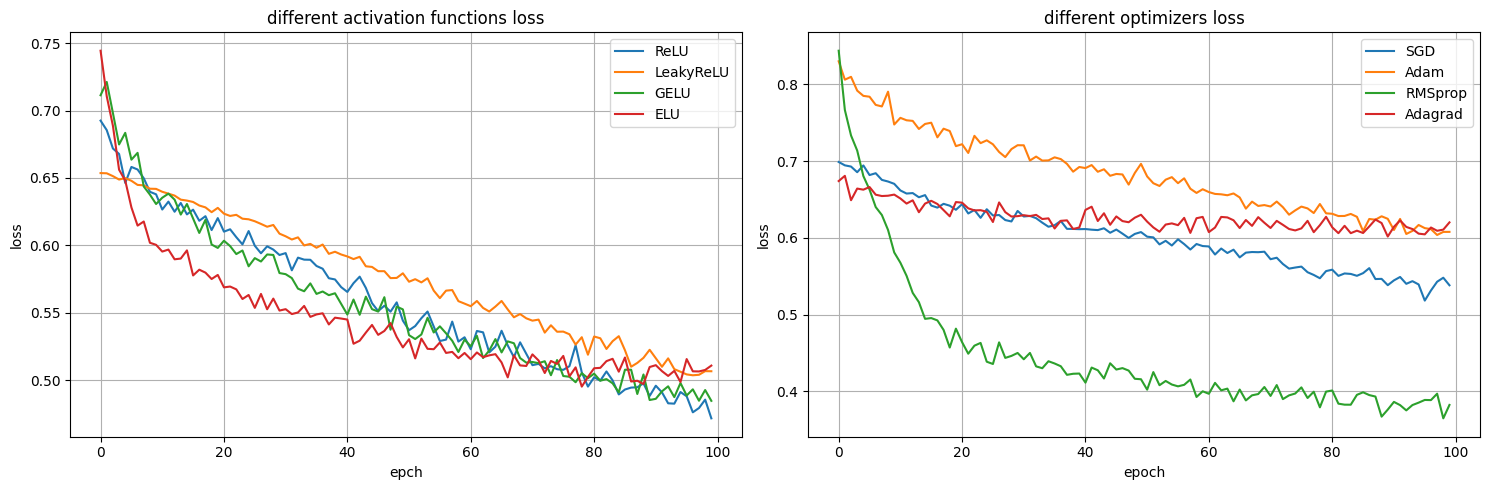

In [ ]:
import torch
from torch import nn, optim, from_numpy
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False     # 正常顯示負號

# 載入數據
xy = np.loadtxt('/content/diabetes.csv.gz', delimiter=',', dtype=np.float32)
x_data = from_numpy(xy[:, 0:-1])
y_data = from_numpy(xy[:, [-1]])

# 數據標準化
x_mean = x_data.mean(dim=0)
x_std = x_data.std(dim=0)
x_data = (x_data - x_mean) / x_std

print(f'數據形狀 - 特徵: {x_data.shape} | 標籤: {y_data.shape}')

class DeepModel(nn.Module):
    def __init__(self, activation_fn=nn.ReLU()):
        super(DeepModel, self).__init__()
        self.layers = nn.Sequential(

            nn.Linear(8, 64),
            activation_fn,
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            activation_fn,
            nn.BatchNorm1d(32),
            nn.Dropout(0.3),

            nn.Linear(32, 16),
            activation_fn,
            nn.BatchNorm1d(16),
            nn.Dropout(0.3),

            nn.Linear(16, 8),
            activation_fn,
            nn.BatchNorm1d(8),
            nn.Dropout(0.3),

            nn.Linear(8, 4),
            activation_fn,
            nn.BatchNorm1d(4),

            nn.Linear(4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

def train_model(model, optimizer_name='Adam', lr=0.0015, epochs=100):
    criterion = nn.BCELoss(reduction='mean')

    # 調整優化器參數
    optimizers = {
        'SGD': optim.SGD(model.parameters(), lr=lr, momentum=0.9),  # 添加動量
        'Adam': optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5),  # 添加L2正則化
        'RMSprop': optim.RMSprop(model.parameters(), lr=lr, momentum=0.9),
        'Adagrad': optim.Adagrad(model.parameters(), lr=lr, weight_decay=1e-5)
    }
    optimizer = optimizers[optimizer_name]

    # 學習率調度器
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10, verbose=True
    )

    losses = []

    for epoch in range(epochs):
        model.train()  # 設置為訓練模式
        y_pred = model(x_data)
        loss = criterion(y_pred, y_data)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 更新學習率
        scheduler.step(loss)

        if (epoch + 1) % 20 == 0:
            print(f'Epoch: {epoch + 1}/{epochs} | Loss: {loss.item():.4f}')

    return losses

# 比較不同激活函數
activation_functions = {
    'ReLU': nn.ReLU(),
    'LeakyReLU': nn.LeakyReLU(negative_slope=0.1),  # 調整負斜率
    'GELU': nn.GELU(),  # 使用GELU替代Tanh
    'ELU': nn.ELU(alpha=1.0)
}

print("\n===== 比較不同激活函數 =====")
activation_results = {}
for name, activation in activation_functions.items():
    print(f"\n使用激活函數: {name}")
    model = DeepModel(activation_fn=activation)
    losses = train_model(model, optimizer_name='Adam', lr=0.0015, epochs=100)
    activation_results[name] = losses

# 比較不同優化器
optimizers_to_test = ['SGD', 'Adam', 'RMSprop', 'Adagrad']
optimizer_results = {}

print("\n===== 比較不同優化器 =====")
for opt_name in optimizers_to_test:
    print(f"\n使用優化器: {opt_name}")
    model = DeepModel()
    losses = train_model(
        model,
        optimizer_name=opt_name,
        lr=0.001 if opt_name != 'SGD' else 0.01,  # SGD使用更大的學習率
        epochs=100
    )
    optimizer_results[opt_name] = losses

# 繪製結果比較圖
plt.figure(figsize=(15, 5))

# 激活函數比較圖
plt.subplot(1, 2, 1)
for name, losses in activation_results.items():
    plt.plot(losses, label=name)
plt.title('different activation functions loss')
plt.xlabel('epch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)

# 優化器比較圖
plt.subplot(1, 2, 2)
for name, losses in optimizer_results.items():
    plt.plot(losses, label=name)
plt.title('different optimizers loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()